In [2]:
# from pgmpy.models import DiscreteBayesianNetwork
# from pgmpy.inference import VariableElimination
# from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import pymc as pm
import numpy as np
import arviz as az
import aesara.tensor as at
import matplotlib.pyplot as plt

In [3]:
# Build PyMC model
# Simulate data
np.random.seed(42)
n_samples = 100
time = np.arange(n_samples)

# Simulated traffic data with a periodic pattern
traffic_data = 50 + 10 * np.sin(2 * np.pi * time / 24) + np.random.normal(0, 5, n_samples)
# Simulated weather data (binary: 0 = Bad Weather, 1 = Good Weather)
weather_data = np.random.binomial(1, 0.2, n_samples)  # 20% chance of good weather
# Simulated risk data (0 = Low, 1 = Medium, 2 = High)
risk_data = np.random.choice([0, 1, 2], size=n_samples, p=[0.6, 0.3, 0.1])

with pm.Model() as model:

    # -------------------------
    # 1. Time Series Modeling for Traffic Forecasting
    # -------------------------

    # Prior for traffic fluctuation (uncertainty in the model)
    sigma_traffic = pm.Exponential("sigma_traffic", 1.0)

    # Priors for the trend and seasonal effects
    alpha_traffic = pm.Normal("alpha_traffic", mu=50, sigma=10)  # Baseline traffic level
    beta_time = pm.Normal("beta_time", mu=0, sigma=1)  # Trend effect (increase or decrease over time)
    beta_seasonal = pm.Normal("beta_seasonal", mu=10, sigma=5)  # Seasonal effect (e.g., daily peaks)

    # Traffic forecast equation: Trend + Seasonality
    mu_traffic = alpha_traffic + beta_time * time + beta_seasonal * pm.math.sin(2 * np.pi * time / 24)

    # Observed traffic data modeled as a normal distribution
    obs_traffic = pm.Normal("obs_traffic", mu=mu_traffic, sigma=sigma_traffic, observed=traffic_data)

    # -------------------------
    # 2. Logistic Regression for Risk Prediction
    # -------------------------

    # Priors for risk prediction model
    # Coefficients for each class (except the reference class, which is 0)
    beta_risk_1 = pm.Normal("beta_risk_1", mu=0, sigma=1)
    beta_traffic_1 = pm.Normal("beta_traffic_1", mu=0, sigma=1)
    beta_weather_1 = pm.Normal("beta_weather_1", mu=0, sigma=1)

    beta_risk_2 = pm.Normal("beta_risk_2", mu=0, sigma=1)
    beta_traffic_2 = pm.Normal("beta_traffic_2", mu=0, sigma=1)
    beta_weather_2 = pm.Normal("beta_weather_2", mu=0, sigma=1)

    # Linear predictors for Medium (1) and High (2) risk
    logits_1 = beta_risk_1 + beta_traffic_1 * traffic_data + beta_weather_1 * weather_data
    logits_2 = beta_risk_2 + beta_traffic_2 * traffic_data + beta_weather_2 * weather_data

    # Stack logits: the reference class (Low risk = 0) has logit = 0
    logits = at.stack([at.zeros_like(logits_1), logits_1, logits_2], axis=1)

    # Apply softmax to get class probabilities
    p_risk = at.nnet.softmax(logits)

    # Observed risk data
    obs_risk = pm.Categorical("obs_risk", p=p_risk, observed=risk_data)

    # -------------------------
    # 3. Monte Carlo Sampling (MCMC)
    # -------------------------

    # Use Markov Chain Monte Carlo (MCMC) to sample from the posterior distribution
    trace = pm.sample(5000, return_inferencedata=True, target_accept=0.95)

az.plot_trace(trace)
plt.tight_layout()
plt.show()

AttributeError: module aesara has no attribute stack

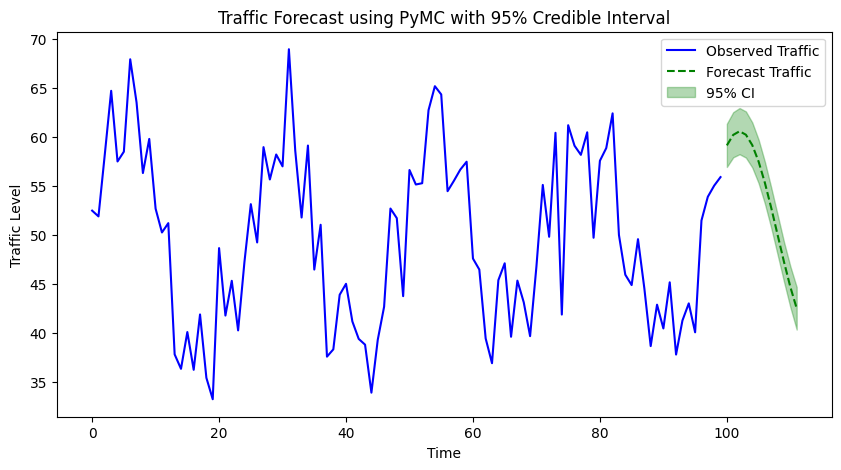

In [ ]:
# Forecasting Traffic for Future Periods

# Generate future time points (next 12 days)
forecast_x = np.arange(len(traffic_data), len(traffic_data) + 12)

# Extract posterior samples
alpha_samples = trace.posterior["alpha_traffic"].stack(sample=("chain", "draw")).values
beta_time_samples = trace.posterior["beta_time"].stack(sample=("chain", "draw")).values
beta_seasonal_samples = trace.posterior["beta_seasonal"].stack(sample=("chain", "draw")).values

# Compute forecast mean (for line plot)
alpha_mean = alpha_samples.mean()
beta_time_mean = beta_time_samples.mean()
beta_seasonal_mean = beta_seasonal_samples.mean()
forecast_y = alpha_mean + beta_time_mean * forecast_x + beta_seasonal_mean * np.sin(2 * np.pi * forecast_x / 24)

# Compute forecast samples for credible interval
N = alpha_samples.shape[0]
forecast_x_expanded = np.tile(forecast_x, (N, 1))
forecast_samples = (
    alpha_samples[:, None] +
    beta_time_samples[:, None] * forecast_x_expanded +
    beta_seasonal_samples[:, None] * np.sin(2 * np.pi * forecast_x_expanded / 24)
)

# Compute 95% credible interval
forecast_low = np.percentile(forecast_samples, 2.5, axis=0)
forecast_high = np.percentile(forecast_samples, 97.5, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, traffic_data, label="Observed Traffic", color="b")
plt.plot(forecast_x, forecast_y, label="Forecast Traffic", linestyle="dashed", color="g")
plt.fill_between(forecast_x, forecast_low, forecast_high, color="g", alpha=0.3, label="95% CI")
plt.legend()
plt.title("Traffic Forecast using PyMC with 95% Credible Interval")
plt.xlabel("Time")
plt.ylabel("Traffic Level")
plt.show()


In [ ]:
# Define the Bayesian Network structure
# Creates a Bayesian network model named 'model' with the specified dependencies:
# Traffic and Weather directly influence Risk.
# Traffic directly influences AirQuality.
# AirQuality also influences Risk.
model = DiscreteBayesianNetwork([('Traffic', 'Risk'), ('Weather', 'Risk'), ('Traffic', 'AirQuality'), ('AirQuality', 'Risk')])

In [ ]:
# Define the Conditional Probability Distributions (CPDs)
# CPDs specify the probability of each state of a variable given the states of its parents.
# variable: The name of the variable.
# variable_card: The number of possible states for the variable.
# values: A list of lists representing the probabilities. The order matters and depends on the evidence.
# evidence: A list of the parent variables.
# evidence_card: A list of the number of states for each parent variable (in the same order as 'evidence').
ram = {
    ('Low', 'Good', 0): [0.85, 0.10, 0.05],  # Low T, Good W, AQ=0: Low, Med, High
    ('Low', 'Good', 1): [0.75, 0.20, 0.05],  # Low T, Good W, AQ=1: Low, Med, High
    ('Low', 'Bad', 0):  [0.55, 0.35, 0.10],  # Low T, Bad W, AQ=0: Low, Med, High
    ('Low', 'Bad', 1):  [0.45, 0.45, 0.10],  # Low T, Bad W, AQ=1: Low, Med, High
    ('High', 'Good', 0): [0.65, 0.25, 0.10], # High T, Good W, AQ=0: Low, Med, High
    ('High', 'Good', 1): [0.55, 0.35, 0.10], # High T, Good W, AQ=1: Low, Med, High
    ('High', 'Bad', 0):  [0.25, 0.45, 0.30], # High T, Bad W, AQ=0: Low, Med, High
    ('High', 'Bad', 1):  [0.15, 0.55, 0.30], # High T, Bad W, AQ=1: Low, Med, High
}

# Define the order of evidence states for the columns in 'values'
evidence_order = [('Low', 'Good', 0), ('High', 'Good', 0), ('Low', 'Bad', 0), ('High', 'Bad', 0),
                  ('Low', 'Good', 1), ('High', 'Good', 1), ('Low', 'Bad', 1), ('High', 'Bad', 1)]

ram_values = np.array([list(ram[key]) for key in evidence_order]).T
cpd_traffic = TabularCPD(variable='Traffic', variable_card=2, values=[[0.7], [0.3]])
cpd_weather = TabularCPD(variable='Weather', variable_card=2, values=[[0.8], [0.2]])
cpd_air_quality = TabularCPD(variable='AirQuality', variable_card=2,
                             values=[[0.9, 0.6],  # P(AQ=0 | T=0, T=1)
                                     [0.1, 0.4]],
                             evidence=['Traffic'], evidence_card=[2])
cpd_risk = TabularCPD(variable='Risk', variable_card=3,
                     values=ram_values,
                     evidence=['Traffic', 'Weather', 'AirQuality'], evidence_card=[2, 2, 2])


In [ ]:
# Add CPDs to the model
model.add_cpds(cpd_traffic, cpd_weather, cpd_air_quality, cpd_risk)
model.check_model()

True

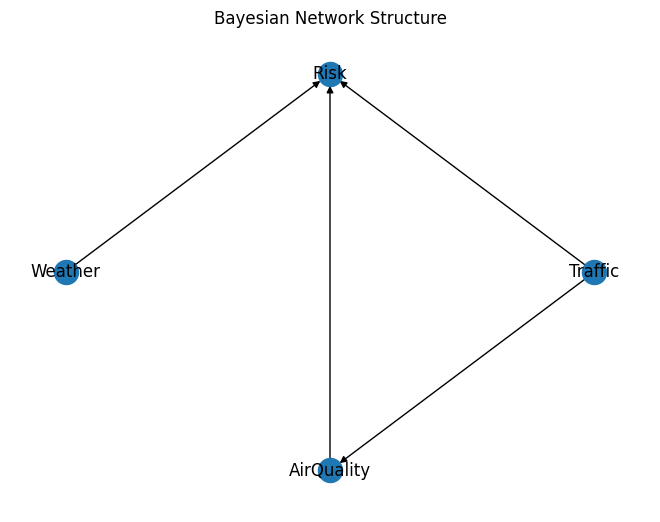

In [ ]:
# Visualize the DAG
pos = nx.circular_layout(model)
nx.draw(model, pos=pos, with_labels=True)
plt.title("Bayesian Network Structure")
plt.show()

In [ ]:
# Perform inference
predicted_risks = { 'Low': [], 'Medium': [], 'High': [] }
inference = VariableElimination(model)
threshold = 60
forecast_traffic_states = (forecast_samples > threshold).astype(int)

for i in range(forecast_traffic_states.shape[1]):
    traffic_states_for_day = forecast_traffic_states[:, i]
    predicted_risk_for_day = {'Low': [], 'Medium': [], 'High': []}

    for traffic_state in traffic_states_for_day:
        predicted_risk = inference.query(
            variables=['Risk'],
            evidence={'Traffic': traffic_state, 'Weather': 1, 'AirQuality': 0}
        )

        # Append probabilities for Low, Medium, and High
        predicted_risk_for_day['Low'].append(predicted_risk.values[0])  # Low risk
        predicted_risk_for_day['Medium'].append(predicted_risk.values[1])  # Medium risk
        predicted_risk_for_day['High'].append(predicted_risk.values[2])  # High risk

    # Append each day's risk probabilities
    for risk_level in predicted_risk_for_day:
        predicted_risks[risk_level].append(np.mean(predicted_risk_for_day[risk_level]))

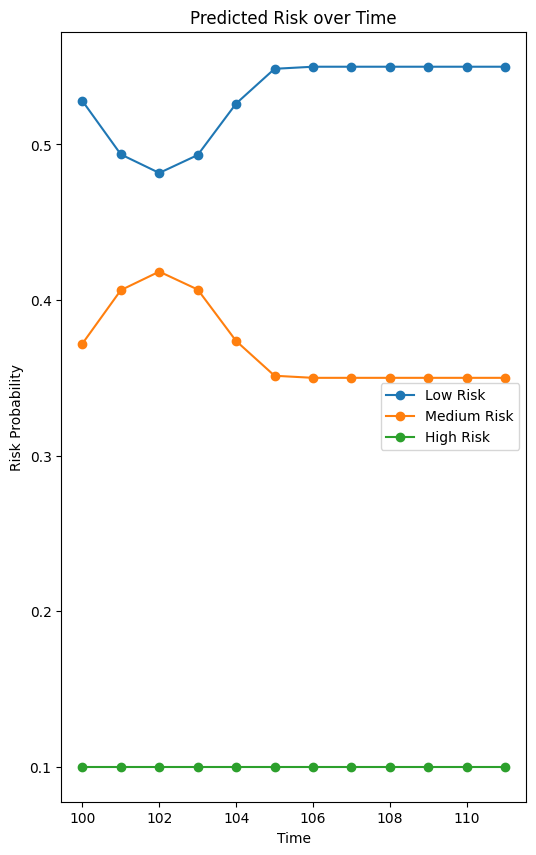

In [ ]:
# Plot all risk levels in one chart
plt.figure(figsize=(6, 10))
for risk_level in predicted_risks:
    plt.plot(forecast_x, predicted_risks[risk_level], marker='o', linestyle='-', label=f"{risk_level} Risk")

plt.xlabel("Time")
plt.ylabel("Risk Probability")
plt.title("Predicted Risk over Time")
plt.legend()
plt.show()
